In [1]:
import os
import sys
import re
import matplotlib

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import matplotlib.colors as colors

from scipy.stats     import rankdata
from matplotlib      import cm
from sklearn.metrics import mean_squared_error
from functools       import reduce

#sys.path.append('../../docs/')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype']  = 42

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 1000)


# importances argument should be a numpy matrix
normalization = {
    'ExErr'  : lambda importances: rankdata(np.abs(importances).max() - np.abs(importances), axis=1),
    'None'   : lambda importances: importances,
    'Abs'    : lambda importances: np.abs(importances),
    'AbsMax' : lambda importances: np.abs(importances)/np.abs(importances).max(axis=1)[:, None],
}

# Comparing SHAP and PE over the original equations

This notebook is specific for analyzing the results generated by the PEvsSHAP experiment. In this experiment, we use the original equation to generate explanations with two equivalent explainers ( (SHAP, PE_adj), and (SHAP_adj, PE) ), then we measure the NRMSE between their explanations. As the adjusted versions are made to retrieve the same values computed by one original explainer, it is a measure of approximation error between them.

They are evaluated from the global and local perspective, just like the other explainers.

In [2]:
explainers           = ['gradient', 'gradient_adj', 'SHAP', 'SHAP_adj']
normalization_method = 'ExErr'
datasets_folder      = '../../datasets/'

# Function to preprocess the data

In [3]:
# parses the importances information on a matrix
def importances_matrix(dataframe_slice):
        
    return np.array([np.fromstring(dataframe_slice[f'ImportanceObs{i}'].values[0][1:-1], dtype=np.float64, sep=' ')
        for i in range(100)])


# Creating a dataset object for the regressor
def preprocess_data(regressor, regressorAcronym, groundtruth_method):
    global_data = pd.read_csv(f'../../results/tabular_raw/{regressor}-globalexplanations.csv')
    local_data  = pd.read_csv(f'../../results/tabular_raw/{regressor}-localexplanations.csv')
    
    global_gt_data = pd.read_csv(f'../../results/ground_truth/{groundtruth_method}_groundtruth-globalexplanations.csv')
    local_gt_data  = pd.read_csv(f'../../results/ground_truth/{groundtruth_method}_groundtruth-localexplanations.csv')

    # Columns will have the mean or median
    columns = ['Dataset'] + [f'{scope}-{explainer}-{regressorAcronym}'
                            for explainer in explainers
                            for scope in ['Global', 'Local']]
    
    processed_data  = {c:[] for c in columns}
        
    # Finding only datasets with results reported
    datasets = set(global_data['Dataset'].tolist() + local_data['Dataset'].tolist())
    
    nmses = {explainer:[] for explainer in explainers}
        
    # now we'll iterate through the dataset
    for ds in sorted(datasets):
  
        global_gt = normalization[normalization_method]( importances_matrix(global_gt_data[global_gt_data['Dataset']==ds]) )
        local_gt  = normalization[normalization_method]( importances_matrix(local_gt_data[local_gt_data['Dataset']==ds]) )
        
        processed_data['Dataset'].append(ds)

        for explainer in explainers:
            #np.seterr(all='ignore')
            
            global_importances = normalization[normalization_method](importances_matrix(global_data[
                (global_data['Dataset']==ds) &
                (global_data['Explainer']==f'Global-{explainer}-{regressorAcronym}')
            ]))
            
            local_importances = normalization[normalization_method](importances_matrix(local_data[
                (local_data['Dataset']==ds) &
                (local_data['Explainer']==f'Local-{explainer}-{regressorAcronym}')
            ]))

            # Global: error of the mean. Local: mean of the errors

            # using RMSE ------------------------------------------
            global_error = mean_squared_error(np.mean(global_gt, axis=0), np.mean(global_gt, axis=0), squared=False) 
            local_error = np.mean([mean_squared_error(local_gt[i, :], local_importances[i, :], squared=False)
                                   for i in range(100)])

            # using NRMSE -----------------------------------------
            y_real, y_pred = np.mean(global_gt, axis=0), np.mean(global_gt, axis=0)

            if np.max(y_real) != np.min(y_real):
                global_error = mean_squared_error(y_real, y_pred, squared=False) / (np.max(y_real) - np.min(y_real))
            else: # constant importances
                global_error = mean_squared_error(y_real, y_pred, squared=False)


            local_nmses = []
            for v in range(local_gt.shape[1]):
                if np.max(local_gt[:, v]) != np.min(local_gt[:, ]):
                    # nrmse for the dataset-explainer
                    local_nmses.append(mean_squared_error(local_gt[:, v], local_importances[:, v], squared=True)/(np.max(local_gt[:, v]) - np.min(local_gt[:, ])) )

                    # saving all nrmses to see the distribution after execution
                    nmses[explainer].append( mean_squared_error(local_gt[:, v], local_importances[:, v], squared=True)/(np.max(local_gt[:, v]) - np.min(local_gt[:, ])) )
                else:
                    local_nmses.append(mean_squared_error(local_gt[:, v], local_importances[:, v], squared=True))

                    # saving all nrmses to see the distribution after execution
                    nmses[explainer].append( mean_squared_error(local_gt[:, v], local_importances[:, v], squared=True))
                    
            # taking the mean for the local explanations
            local_error = np.mean(local_nmses)
                
            processed_data[f'Global-{explainer}-{regressorAcronym}'].append(global_error)
            processed_data[f'Local-{explainer}-{regressorAcronym}'].append(local_error)
                
    return pd.DataFrame(processed_data), nmses

# Applying the pre processing for the PEvsSHAP results

In [4]:
SHAPGT_PEvsSHAP_processed,     SHAPGT_nmses     = preprocess_data('PEvsSHAP', 'PEvsSHAP', 'SHAP')
gradientGT_PEvsSHAP_processed, gradientGT_nmses = preprocess_data('PEvsSHAP', 'PEvsSHAP', 'gradient')

SHAPGT_PEvsSHAP_processed     = SHAPGT_PEvsSHAP_processed.set_index('Dataset').sort_index(axis=1).dropna(axis=0)
gradientGT_PEvsSHAP_processed = gradientGT_PEvsSHAP_processed.set_index('Dataset').sort_index(axis=1).dropna(axis=0)

SHAPGT_PEvsSHAP_processed.columns     = ['SHAP_GT-'+col for col in SHAPGT_PEvsSHAP_processed.columns]
gradientGT_PEvsSHAP_processed.columns = ['PE_GT-'+col for col in gradientGT_PEvsSHAP_processed.columns]

In [8]:
# Merging the results

df_merged = reduce(
    lambda left, right: pd.merge(left,right,on=['Dataset'], how='inner'),
    [SHAPGT_PEvsSHAP_processed, gradientGT_PEvsSHAP_processed]
).sort_index(axis=1)

display(df_merged.round(4).head())

,PE_GT-Global-SHAP-PEvsSHAP,PE_GT-Global-SHAP_adj-PEvsSHAP,PE_GT-Global-gradient-PEvsSHAP,PE_GT-Global-gradient_adj-PEvsSHAP,PE_GT-Local-SHAP-PEvsSHAP,PE_GT-Local-SHAP_adj-PEvsSHAP,PE_GT-Local-gradient-PEvsSHAP,PE_GT-Local-gradient_adj-PEvsSHAP,SHAP_GT-Global-SHAP-PEvsSHAP,SHAP_GT-Global-SHAP_adj-PEvsSHAP,SHAP_GT-Global-gradient-PEvsSHAP,SHAP_GT-Global-gradient_adj-PEvsSHAP,SHAP_GT-Local-SHAP-PEvsSHAP,SHAP_GT-Local-SHAP_adj-PEvsSHAP,SHAP_GT-Local-gradient-PEvsSHAP,SHAP_GT-Local-gradient_adj-PEvsSHAP
Dataset,,,,,,,,,,,,,,,,
I.10.7,0.0,0.0,0.0,0.0,0.4767,0.2850,0.0,0.5350,0.0,0.0,0.0,0.0,0.0,0.1100,0.3133,0.0933
I.11.19,0.0,0.0,0.0,0.0,0.9118,0.7498,0.0,1.1518,0.0,0.0,0.0,0.0,0.0,0.0867,0.9118,0.1220
I.12.1,0.0,0.0,0.0,0.0,0.4750,0.3450,0.0,0.5550,0.0,0.0,0.0,0.0,0.0,0.1300,0.4750,0.1200
I.12.11,0.0,0.0,0.0,0.0,0.6665,0.5855,0.0,0.9645,0.0,0.0,0.0,0.0,0.0,0.0620,0.6665,0.3100
I.12.2,0.0,0.0,0.0,0.0,0.6242,0.5758,0.0,0.5871,0.0,0.0,0.0,0.0,0.0,0.1017,0.5471,0.2550


# Boxplot of NRMSE distribution for each combination of ground-truth and explainer

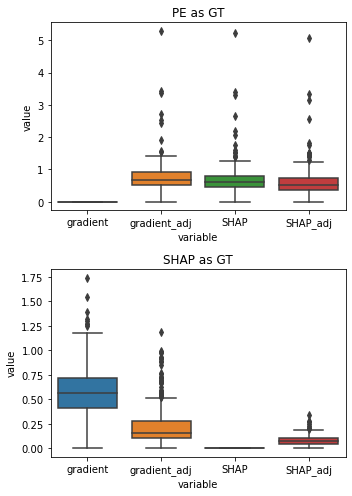

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(5, 7))

for title, ax, data in zip(['PE as GT', 'SHAP as GT'], fig.axes, [gradientGT_nmses, SHAPGT_nmses]):
    sns.boxplot(
        x       = "variable",
        y       = "value",
        data    = pd.melt(pd.DataFrame(data)),
        ax=ax,
        zorder  = 3,
    )
    ax.set_title(title)
    
    #ax.set_ylim([0, 10])

    plt.tight_layout()
plt.show()

# Creating boxplot comparing global and local performances between (SHAP, PE_adj) and (SHAP_adj, PE)

Local


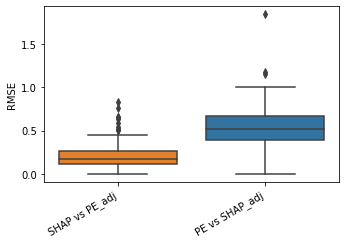

Global


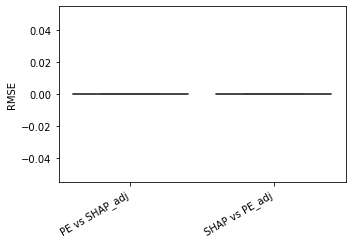

In [7]:
for scope in ['Local', 'Global']:
    print(scope)

    if scope == 'Local':
        combinations = np.array(['PE_GT-Local-SHAP_adj-PEvsSHAP', 'SHAP_GT-Local-gradient_adj-PEvsSHAP'])
    elif scope == 'Global':
        combinations = np.array(['PE_GT-Global-SHAP_adj-PEvsSHAP', 'SHAP_GT-Global-gradient_adj-PEvsSHAP'])
            
    order = np.argsort(np.mean(df_merged[combinations].values, axis=0))

    fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))

    sns.boxplot(
        x       = "variable",
        y       = "value",
        data    = pd.melt(df_merged[combinations[order]]), ax=ax,
        palette = np.array(sns.color_palette(n_colors=len(combinations)))[order],
        zorder  = 3
    )
    
    ax.set_xticklabels(
        [(l.replace(f'{scope}-', '').replace('-PEvsSHAP', '').
          replace('gradient', 'PE').replace('_GT', '').
          replace('-', ' vs ')) for l in combinations[order]],
        rotation = 30,
        ha = 'right'
    )
    
    ax.set_xlabel('')
    ax.set_ylabel(f'RMSE')
    
    plt.tight_layout()
    
    plt.savefig(f'../../results/figures/{scope}-{normalization_method}-SHAPvsPE.eps', format='eps', dpi=1000)
    plt.show()